<a href="https://colab.research.google.com/github/Shanlans/model_interpretable/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from glob import glob
from tensorflow.contrib.slim.python.slim.nets.vgg import vgg_16

slim = tf.contrib.slim


In [2]:
!wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
!tar -zxvf vgg_16_2016_08_28.tar.gz


Redirecting output to ‘wget-log’.
vgg_16.ckpt


###0. Let's start

In [3]:
!wget http://apopka-1x1yusplq.stackpathdns.com/wp-content/uploads/2017/12/gfhdgfgfgdfgdf.jpg


Redirecting output to ‘wget-log.1’.


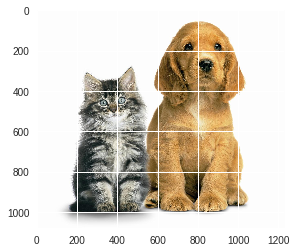

In [4]:
img = cv2.imread('gfhdgfgfgdfgdf.jpg')
imgSHOW = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(imgSHOW)

In [5]:
class_id = {}
with open('class_id.txt','r') as inf:
    class_id= eval(inf.read())
print(class_id)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

##1. Setup model


> Here, use slim **VGG 16** to explain the work!


>Note, the last layer shape should be number of class.



> ![alt text](https://qph.fs.quoracdn.net/main-qimg-83c7dee9e8b039c3ca27c8dd91cacbb4)










In [0]:
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32, shape=(1,224,224,3), name='input')
_, endpoints = vgg_16(x, 1000, is_training=False,dropout_keep_prob=1.0)

> Meanwhile, through calling endpoint['name'], we can get the node including end point and others.






> In this case, for end point, we have two choices, one is 'vgg_16/fc8', another is 'global_pool'


---



> Here, we list the name of every single node for your reference. We can use one of them to test this work to get if each of layer to show the different effect on CAM GRAD


> 'vgg_16/conv1/conv1_1', 'vgg_16/conv1/conv1_2', 'vgg_16/pool1', 'vgg_16/conv2/conv2_1', 'vgg_16/conv2/conv2_2', 'vgg_16/pool2', 'vgg_16/conv3/conv3_1', 'vgg_16/conv3/conv3_2', 'vgg_16/conv3/conv3_3', 'vgg_16/pool3', 'vgg_16/conv4/conv4_1', 'vgg_16/conv4/conv4_2', 'vgg_16/conv4/conv4_3', 'vgg_16/pool4', 'vgg_16/conv5/conv5_1', 'vgg_16/conv5/conv5_2', 'vgg_16/conv5/conv5_3', 'vgg_16/pool5', 'vgg_16/fc6', 'vgg_16/fc7', 'vgg_16/fc8'


In [0]:
check_node_name = 'vgg_16/conv5/conv5_3'
end_node_name = 'vgg_16/fc8'

In [0]:
check_node = endpoints[check_node_name]
end_node = endpoints[end_node_name]

##2. Backprop to the check node



> We need to get $Class\,C$ first, here we choose the prediction result




In [0]:
prediction = tf.argmax(end_node, axis=1)
check_id = tf.constant((1,285),dtype=tf.int32)
one_hot = tf.sparse_to_dense(check_id, [1000], 1.0)
signal = tf.multiply(end_node, one_hot)
y_c = tf.reduce_mean(signal)





> Then, calculate:


> $$Grad = \frac{\partial y^c}{\partial A^k_{ij}}$$






In [0]:
grads = tf.gradients(y_c, check_node)[0]
norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))



> Then, global average pooling:


> $$\alpha^c_k = \frac{1}{Z}\sum_i\sum_j Grad $$





In [0]:
k_size = norm_grads.get_shape().as_list()[1]
weights = tf.nn.avg_pool(grads,[1,k_size,k_size,1],strides=[1,k_size,k_size,1],padding='VALID',name='Global_Average_Pooling')



> Then, calculate $Relu$ to get the final Grad-CAM



>$$L^c_{Grad-CAM} = ReLU\left(\sum_k\alpha^c_kA^k\right)$$






In [0]:
Grad_CAM = tf.nn.relu(tf.reduce_sum(tf.multiply(weights,check_node),axis=-1))

In [0]:
model_path = 'vgg_16.ckpt'
image_list = glob('*.jpg')

INFO:tensorflow:Restoring parameters from vgg_16.ckpt


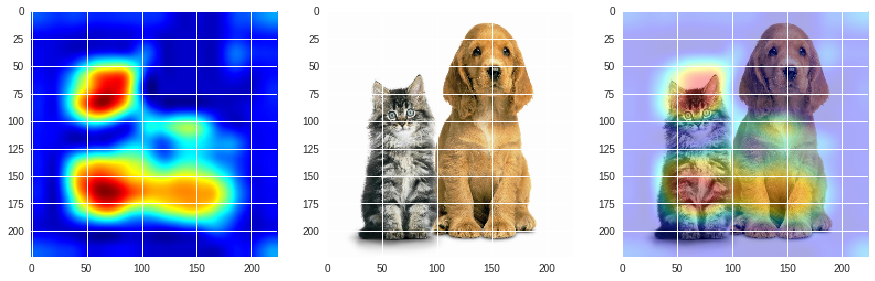

In [42]:
with tf.Session() as sess:
    tf.global_variables_initializer()
    variables = slim.get_variables_to_restore()
    var_dict = {}
    for v,s in tf.contrib.framework.list_variables(model_path):
        var_dict[v] = s
    var_restore = []
    for v in variables:
        if v.name[:-2] in var_dict:
            if v.shape == var_dict[v.name[:-2]]:
                var_restore.append(v)
    saver = tf.train.Saver(var_restore)
    saver.restore(sess, model_path)
    
    for image_path in image_list:
        img = cv2.imread(image_path)
        img = cv2.resize(img, (224,224))
        img = np.reshape(img, (1,224,224,3))
        
        gra_cam,predict,all_predict = sess.run([Grad_CAM,prediction,end_node], feed_dict = {x:img})
        cam = cv2.resize(np.squeeze(gra_cam),(224,224),interpolation = cv2.INTER_CUBIC)
        cam = (cam-np.min(cam))/(np.max(cam)-np.min(cam))
        cam_c = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        cam_c = cv2.cvtColor(cam_c, cv2.COLOR_BGR2RGB)
        img = np.squeeze(img)
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        alpha = 0.5
        new_img = img+alpha*cam_c
        new_img /= new_img.max()
        fig = plt.figure(figsize=(15,15))
        plt.subplot(131)
        plt.imshow(cam_c)
        plt.subplot(132)
        plt.imshow(img)
        plt.subplot(133)
        plt.imshow(new_img)

In [26]:
maxN = np.squeeze(all_predict).argsort()[-10:][::-1]
for i in maxN:
  print(class_id[i])

clumber, clumber spaniel
Weimaraner
Sussex spaniel
Labrador retriever
Egyptian cat
pajama, pyjama, pj's, jammies
flat-coated retriever
English setter
kuvasz
pedestal, plinth, footstall
